
# Практическое задание в рамках курса Auto ML - решения соревнования на kaggle [Binary Classification with a Bank Dataset](https://www.kaggle.com/competitions/playground-series-s5e8/overview)

# Цели проекта
- Превзойти результаты бейзлайна на LAMA
- Продемонстрировать качественный код
- Использовать стандартные подходы к организации кода (например, Pipeline)
- Провести качественный EDA
- Предоставить подробное описание и обоснование гипотез

# Критерии оценки
## 1. Анализ целевой переменной (максимум 1 балл)
[0.5] Численный анализ:
Для регрессии: распределение таргета, поиск аномальных значений
Для классификации: распределение количества классов
[0.5] Визуализация статистик:
- Изолированный анализ
- Анализ во временном контексте

## 2. Анализ признаков (максимум 4 балла)
[0.5] Типизация признаков (числовые, категориальные, временные) и их распределения
[0.5] Выявление аномальных значений
[0.5] Анализ зависимостей между признаками
[0.5] Анализ пропущенных значений
[0.5] Определение важности признаков (корреляции с таргетом)
[1.0] Графическая визуализация минимум 3-х пунктов выше
[0.5] Анализ возможных преобразований и генерации новых признаков

## 3. Моделирование (максимум 3.5 балла)
[0.25] Обоснование стратегии разделения данных (train-test split)
Особое внимание уделить предотвращению утечки данных
[0.25] LAMA бейзлайн:
- Минимум 2 различные конфигурации
- Выбор лучшего решения
[3.0] Собственное решение (если не удалось побить LLama baseline: 3 x 1.0 балл за различные пайплайны/попытки):
- Выбор модели
- Построение пайплайна (препроцессинг, обработка пропусков, генерация признаков, отбор признаков, финальная модель/ансамбль)
- Оптимизация гиперпараметров

## 4. Общие требования к коду (максимум 1.5 балла)
[0.5] Чистый код:
- Оформление ноутбука
- Соответствие PEP 8
- Правильное именование переменных и функций
- Документирование функций
[0.5] Качество кода:
- Следование принципам SOLID
- Отсутствие спагетти-кода
- Обработка предупреждений и ошибок
- Логгирование
[0.5] Структура решения:
- Оформление в виде self-contained pipeline
- Использование стандартных инструментов (например, sklearn pipeline)


# 1. Установка зависимостей и загрузка данных

In [50]:
!pip install kaggle lightautoml catboost numpy pandas matplotlib seaborn scikit-learn joblib optuna gdown -q


[notice] A new release of pip is available: 24.0 -> 25.3
[notice] To update, run: pip install --upgrade pip


In [51]:
# Создание папки data
!mkdir -p data

# Скачивание ZIP-файла (из гугл ссылки)
file_id = "1i_1x8AeCuojVmHKcwfgh6lvLhIEmh1Nr"
!gdown --id {file_id} -O data/playground-series-s5e8.zip

# Распаковка архива
!unzip -q data/playground-series-s5e8.zip -d data/

/Users/emildenikaev/projects/auto-ml/venv/lib/python3.12/site-packages/gdown/__main__.py:140: FutureWarning: Option `--id` was deprecated in version 4.3.1 and will be removed in 5.0. You don't need to pass it anymore to use a file ID.
  warnings.warn(
Downloading...
From: https://drive.google.com/uc?id=1i_1x8AeCuojVmHKcwfgh6lvLhIEmh1Nr
To: /Users/emildenikaev/projects/auto-ml/data/playground-series-s5e8.zip
100%|██████████████████████████████████████| 15.4M/15.4M [00:05<00:00, 2.85MB/s]


In [53]:
import os
import sys
import random
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from datetime import datetime
import json
import joblib

# sklearn
from sklearn.base import BaseEstimator, TransformerMixin
from sklearn.model_selection import StratifiedKFold
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import FunctionTransformer
from sklearn.metrics import roc_auc_score, precision_recall_curve, average_precision_score
from sklearn.calibration import calibration_curve

# models
from lightautoml.automl.presets.tabular_presets import TabularAutoML
from lightautoml.tasks import Task
from catboost import CatBoostClassifier, Pool
from lightgbm import LGBMClassifier, early_stopping, log_evaluation
import lightgbm as lgb
import optuna

TRAIN_PATH = "data/train.csv"
TEST_PATH = "data/test.csv"
SAMPLE_SUB_PATH = "data/sample_submission.csv"

train = pd.read_csv(TRAIN_PATH)
test = pd.read_csv(TEST_PATH)
sample_sub = pd.read_csv(SAMPLE_SUB_PATH)

print('train:', train.shape)
print('test:', test.shape)
print('sample_sub:', sample_sub.shape)
train.head()


train: (750000, 18)
test: (250000, 17)
sample_sub: (250000, 2)


,id,age,job,marital,education,default,balance,housing,loan,contact,day,month,duration,campaign,pdays,previous,poutcome,y
0,0,42,technician,married,secondary,no,7,no,no,cellular,25,aug,117,3,-1,0,unknown,0
1,1,38,blue-collar,married,secondary,no,514,no,no,unknown,18,jun,185,1,-1,0,unknown,0
2,2,36,blue-collar,married,secondary,no,602,yes,no,unknown,14,may,111,2,-1,0,unknown,0
3,3,27,student,single,secondary,no,34,yes,no,unknown,28,may,10,2,-1,0,unknown,0
4,4,26,technician,married,secondary,no,889,yes,no,cellular,3,feb,902,1,-1,0,unknown,1


In [56]:
# запоминаем для воспроизводимости ноутбука
RANDOM_SEED = 42
os.environ['PYTHONHASHSEED'] = str(RANDOM_SEED)
random.seed(RANDOM_SEED)
np.random.seed(RANDOM_SEED)


## 2. Анализ целевой переменной
Численный анализ и визуализация распределения таргета.


Распределение целевой переменной (столбец "y" — факт подписки на депозит):
y
0    659512
1     90488
Name: count, dtype: int64

Доля положительных случаев (среднее значение): 0.1207


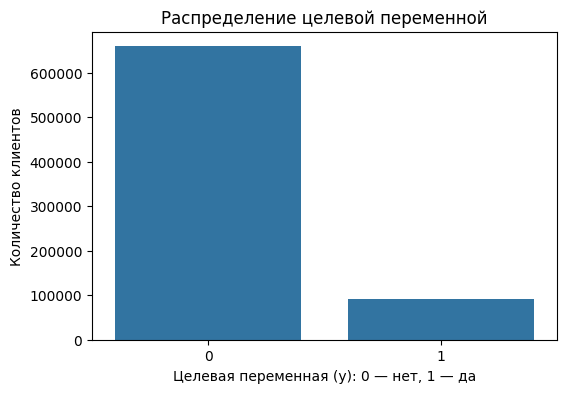

In [57]:
if 'y' in train.columns:
    print('Распределение целевой переменной (столбец "y" — факт подписки на депозит):')
    print(train['y'].value_counts(dropna=False))
    print(f'\nДоля положительных случаев (среднее значение): {train["y"].mean():.4f}')
    plt.figure(figsize=(6, 4))
    sns.countplot(x='y', data=train)
    plt.title('Распределение целевой переменной')
    plt.xlabel('Целевая переменная (y): 0 — нет, 1 — да')
    plt.ylabel('Количество клиентов')
    plt.show()
else:
    print('В обучающей выборке отсутствует столбец "y" (целевая переменная)')

## Обоснование выбора метрики и стратегии:
Целевая переменная несбалансирована (~8.8% положительных случаев).
Используем ROC-AUC, так как он устойчив к дисбалансу.
Для оценки качества будем использовать Stratified K-Fold CV, чтобы сохранять пропорции классов в каждом фолде и избежать случайного перекоса.


## 3. EDA
Типизация признаков, пропуски, описательная статистика, важные визуализации.


Пропущенные значения: 0
Числовые признаки: ['age', 'balance', 'day', 'duration', 'campaign', 'pdays', 'previous']
Категориальные признаки: ['job', 'marital', 'education', 'default', 'housing', 'loan', 'contact', 'month', 'poutcome']


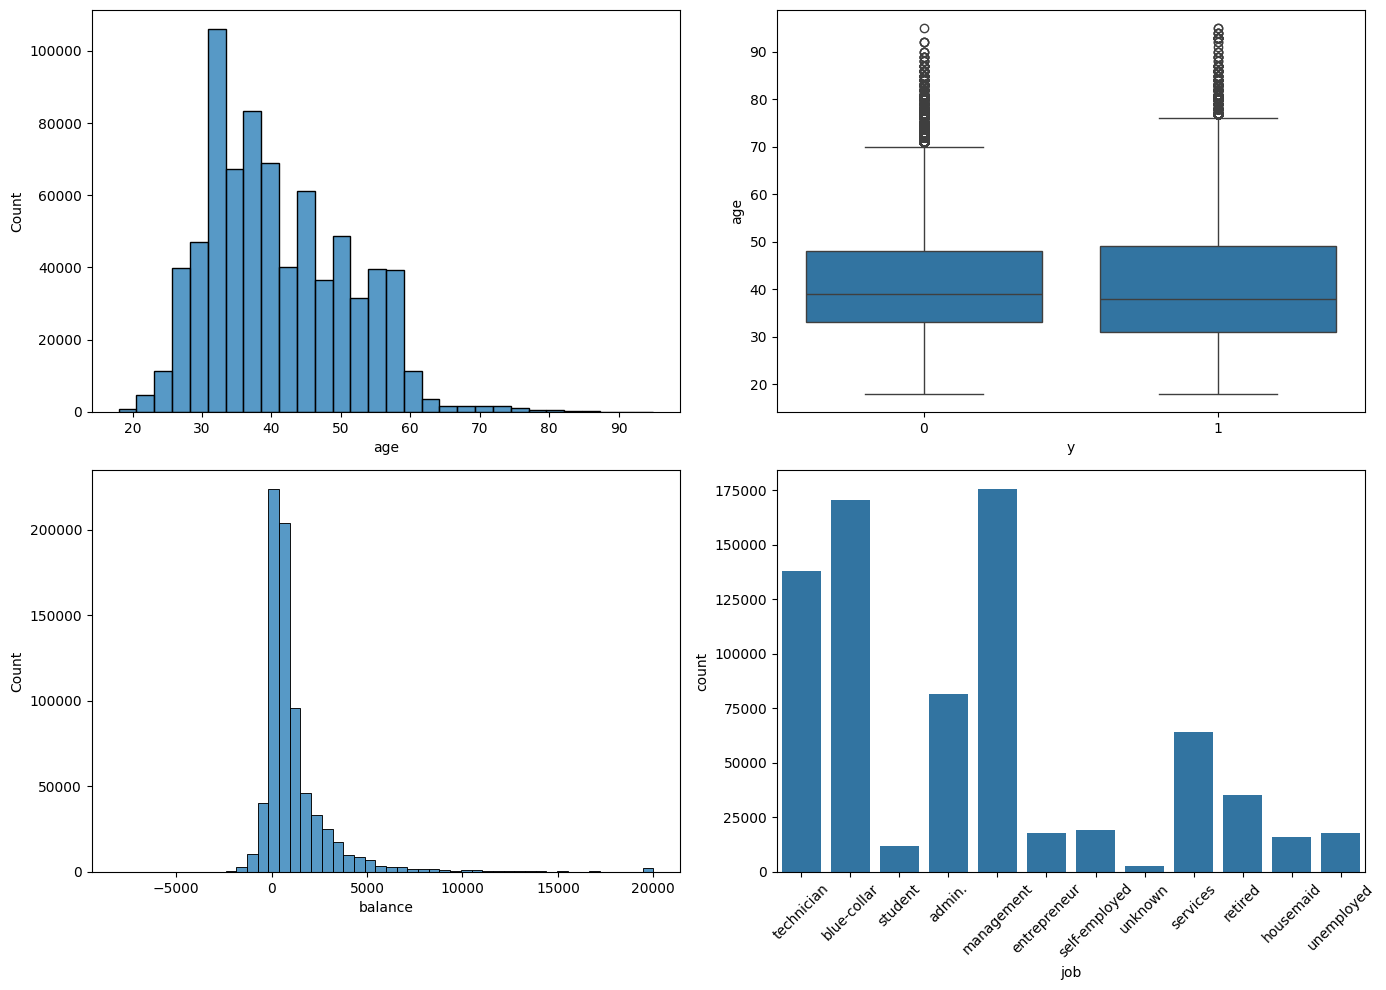

In [58]:
# Пропуски
print("Пропущенные значения:", train.isna().sum().sum())

# Типы признаков
num_cols = train.select_dtypes(include=['int64', 'float64']).columns.tolist()
cat_cols = train.select_dtypes(include=['object']).columns.tolist()
num_cols = [c for c in num_cols if c not in ['id', 'y']]
print("Числовые признаки:", num_cols)
print("Категориальные признаки:", cat_cols)

# Визуализация
fig, axes = plt.subplots(2, 2, figsize=(14, 10))
sns.histplot(train['age'], bins=30, ax=axes[0,0])
sns.boxplot(x='y', y='age', data=train, ax=axes[0,1])
sns.histplot(train['balance'].clip(-10000, 20000), bins=50, ax=axes[1,0])
sns.countplot(x='job', data=train, ax=axes[1,1])
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

## Выводы:
Пропущенные значения отсутствуют
Признак balance имеет сильный правый хвост
Возраст (age) слегка смещён
Категориальные признаки (job, education, marital, etc) - требуют кодирования

### 3.1 Зависимости и корреляции (для числовых признаков)

y           1.000000
duration    0.519283
balance     0.122513
previous    0.119552
pdays       0.089277
age         0.009523
day        -0.049625
campaign   -0.075829
Name: y, dtype: float64

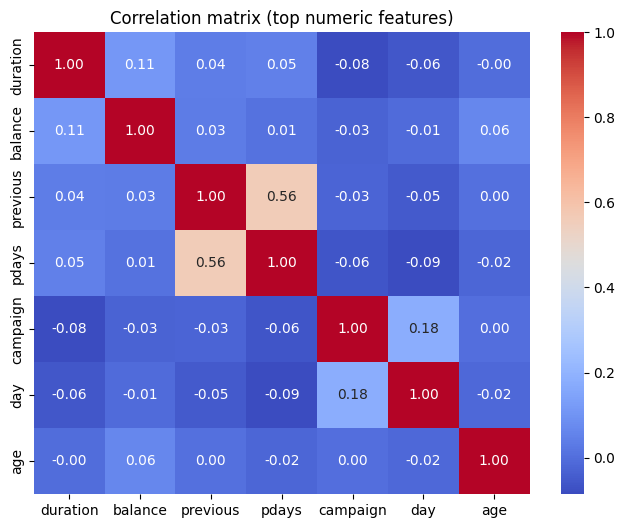

In [59]:
num = [c for c in train.select_dtypes(include=['int64','float64']).columns if c not in ['id','y']]
corr_with_target = train[num + ['y']].corr()['y'].sort_values(ascending=False)
display(corr_with_target)
top_feats = corr_with_target.abs().sort_values(ascending=False).index[1:12].tolist()
plt.figure(figsize=(8,6))
sns.heatmap(train[top_feats].corr(), annot=True, fmt='.2f', cmap='coolwarm')
plt.title('Correlation matrix (top numeric features)')
plt.show()

## 4. Feature Engineering
Генерация простых, но информативных признаков:
- balance_pos: бинарный признак положительного баланса
- age_bin: возрастные группы
- housing_and_loan: взаимодействие двух бинарных признаков

In [60]:
# наименования columns одинаковые для train и test 
initial_cat_cols = [c for c in train.columns if train[c].dtype == 'object' and c not in ['id', 'y']]

def add_basic_features(df):
    df = df.copy()
    if 'balance' in df.columns:
        df['balance_pos'] = (df['balance'] > 0).astype(int)
    if 'age' in df.columns:
        df['age_bin'] = pd.cut(df['age'], bins=[0, 30, 40, 50, 60, 100], labels=False)
    if {'housing', 'loan'}.issubset(df.columns):
        df['housing_and_loan'] = df['housing'].astype(str) + '_' + df['loan'].astype(str)
    return df

train_fe = add_basic_features(train)
test_fe = add_basic_features(test)
display(train_fe.head())


,id,age,job,marital,education,default,balance,housing,loan,contact,...,month,duration,campaign,pdays,previous,poutcome,y,balance_pos,age_bin,housing_and_loan
0,0,42,technician,married,secondary,no,7,no,no,cellular,...,aug,117,3,-1,0,unknown,0,1,2,no_no
1,1,38,blue-collar,married,secondary,no,514,no,no,unknown,...,jun,185,1,-1,0,unknown,0,1,1,no_no
2,2,36,blue-collar,married,secondary,no,602,yes,no,unknown,...,may,111,2,-1,0,unknown,0,1,1,yes_no
3,3,27,student,single,secondary,no,34,yes,no,unknown,...,may,10,2,-1,0,unknown,0,1,0,yes_no
4,4,26,technician,married,secondary,no,889,yes,no,cellular,...,feb,902,1,-1,0,unknown,1,1,0,yes_no



## 5. Encoding: Target и Frequency encoding
Реализация TargetEncoderSmoothing и FrequencyEncoder.


In [61]:
class TargetEncoderSmoothing(BaseEstimator, TransformerMixin):
    def __init__(self, cols=None, target_col='y', min_samples_leaf=100, smoothing=10):
        self.cols = cols
        self.target_col = target_col
        self.min_samples_leaf = min_samples_leaf
        self.smoothing = smoothing
        self.mapping_ = {}

    def fit(self, X, y=None):
        df = X.copy()
        df[self.target_col] = y
        self.global_mean_ = df[self.target_col].mean()
        for col in self.cols:
            stats = df.groupby(col)[self.target_col].agg(['mean','count'])
            smoothing = 1 / (1 + np.exp(-(stats['count'] - self.min_samples_leaf) / self.smoothing))
            stats['smoothed'] = self.global_mean_ * (1 - smoothing) + stats['mean'] * smoothing
            self.mapping_[col] = stats['smoothed'].to_dict()
        return self

    def transform(self, X):
        X_new = X.copy()
        for col in self.cols:
            X_new[col + '_te'] = X_new[col].map(self.mapping_[col]).fillna(self.global_mean_)
        return X_new

class FrequencyEncoder(BaseEstimator, TransformerMixin): # Замена категорий на их частоту в обучающей выборке.
    def __init__(self, cols=None):
        self.cols = cols
        self.freq_maps_ = {}

    def fit(self, X, y=None):
        for col in self.cols:
            self.freq_maps_[col] = X[col].value_counts(normalize=True).to_dict()
        return self

    def transform(self, X):
        X_new = X.copy()
        for col in self.cols:
            X_new[col + '_freq'] = X_new[col].map(self.freq_maps_[col]).fillna(0)
        return X_new


# 6. Подготовка данных для моделирования

In [ ]:
# Применяем FE явно
df_train = add_basic_features(train)
df_test = add_basic_features(test)

# Определяем признаки
features = [c for c in df_train.columns if c not in ['id', 'y']]
cat_cols = [c for c in features if df_train[c].dtype in ['object', 'category']]
num_cols = [c for c in features if c not in cat_cols]

# Приводим категории к строкам (защита от NaN и типов)
for col in cat_cols:
    df_train[col] = df_train[col].astype(str)
    df_test[col] = df_test[col].astype(str)

# Подготавливаем X, y
X = df_train[features]
y = df_train['y']
X_test_raw = df_test[features]


## 7. LightAutoML (LAMA) baseline — 2 конфигурации
1) Быстрая конфигурация (fast) — короткий timeout, только LightGBM  
2) Средняя конфигурация (medium) — больше времени, LGBM + CatBoost + RF  


In [63]:
task = Task('binary', metric='auc')
roles = {'target': 'y'}

## 7.1 Быстрая конфигурация (fast) — короткий timeout, только LightGBM  

In [64]:
aml_fast = TabularAutoML(task=task, timeout=600, cpu_limit=1, general_params={'use_algos': [['lgb']]})
oof_fast = aml_fast.fit_predict(train, roles=roles)
pred_fast = aml_fast.predict(test) 
auc_fast = roc_auc_score(train['y'], oof_fast.data[:, 0])

print(f"LAMA Fast AUC: {auc_fast:.5f}")

LAMA Fast AUC: 0.95433


## 7.2 Средняя конфигурация (medium) - больше времени, LGBM + CatBoost + RF  

In [66]:
aml_med = TabularAutoML(task=task, timeout=3600, cpu_limit=1, general_params={'use_algos': [['lgb', 'cat', 'rf']]})
oof_med = aml_med.fit_predict(train, roles=roles)
pred_med = aml_med.predict(test) 
auc_med = roc_auc_score(train['y'], oof_med.data[:, 0])

print(f"LAMA Medium AUC: {auc_med:.5f}")

/Users/emildenikaev/projects/auto-ml/venv/lib/python3.12/site-packages/numpy/lib/nanfunctions.py:1217: RuntimeWarning: All-NaN slice encountered
  return function_base._ureduce(a, func=_nanmedian, keepdims=keepdims,
[Parallel(n_jobs=4)]: Using backend ThreadingBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done  42 tasks      | elapsed:  1.3min
[Parallel(n_jobs=4)]: Done 192 tasks      | elapsed:  5.6min
[Parallel(n_jobs=4)]: Done 250 out of 250 | elapsed:  7.3min finished
[Parallel(n_jobs=4)]: Using backend ThreadingBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done  42 tasks      | elapsed:    0.2s
[Parallel(n_jobs=4)]: Done 192 tasks      | elapsed:    0.8s
[Parallel(n_jobs=4)]: Done 250 out of 250 | elapsed:    1.0s finished
[Parallel(n_jobs=4)]: Using backend ThreadingBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done  42 tasks      | elapsed:  1.3min
[Parallel(n_jobs=4)]: Done 192 tasks      | elapsed:  5.5min
[Parallel(n_jobs=4)]: Done 250 out of 

LAMA Medium AUC: 0.96340


# 8 pipeline с Optuna

## 8.1. Создание pipeline

In [67]:
def add_features_for_pipeline(X):
    return add_basic_features(X)

preprocessor = Pipeline([
    ('fe', FunctionTransformer(add_features_for_pipeline, validate=False)),
    ('te', TargetEncoderSmoothing(cols=initial_cat_cols)),
    ('feq', FrequencyEncoder(cols=initial_cat_cols))
])

# Применяем препроцессинг
X_proc = preprocessor.fit_transform(X, y)
X_test_proc = preprocessor.transform(X_test_raw)

# Убираем категориальные колонки (они уже закодированы)
X_proc = X_proc.select_dtypes(include=[np.number])
X_test_proc = X_test_proc[X_proc.columns]

## 8.2. Гиперпараметрическая оптимизация (Optuna)

In [68]:
def optuna_objective(trial):
    params = {
        'objective': 'binary',
        'metric': 'auc',
        'verbosity': -1,
        'random_state': RANDOM_SEED,
        'n_estimators': 1000,
        'learning_rate': trial.suggest_float('learning_rate', 0.01, 0.2),
        'num_leaves': trial.suggest_int('num_leaves', 16, 128),
        'max_depth': trial.suggest_int('max_depth', 3, 10),
        'subsample': trial.suggest_float('subsample', 0.6, 1.0),
        'colsample_bytree': trial.suggest_float('colsample_bytree', 0.6, 1.0),
        'reg_alpha': trial.suggest_float('reg_alpha', 0, 10),
        'reg_lambda': trial.suggest_float('reg_lambda', 0, 10),
    }
    
    cv = StratifiedKFold(n_splits=3, shuffle=True, random_state=RANDOM_SEED)
    scores = []
    for tr_idx, val_idx in cv.split(X_proc, y):
        X_tr, X_val = X_proc.iloc[tr_idx], X_proc.iloc[val_idx]
        y_tr, y_val = y.iloc[tr_idx], y.iloc[val_idx]
        model = LGBMClassifier(**params)
        model.fit(X_tr, y_tr, eval_set=[(X_val, y_val)], callbacks=[early_stopping(50), log_evaluation(0)])
        scores.append(roc_auc_score(y_val, model.predict_proba(X_val)[:, 1]))
    return np.mean(scores)

study = optuna.create_study(direction='maximize')
study.optimize(optuna_objective, n_trials=20)
best_params = study.best_params
best_params.update({'n_estimators': 2000, 'random_state': RANDOM_SEED, 'verbosity': -1})

Training until validation scores don't improve for 50 rounds
Did not meet early stopping. Best iteration is:
[1000]	valid_0's auc: 0.967898
Training until validation scores don't improve for 50 rounds
Did not meet early stopping. Best iteration is:
[1000]	valid_0's auc: 0.967643
Training until validation scores don't improve for 50 rounds
Did not meet early stopping. Best iteration is:
[1000]	valid_0's auc: 0.967676
Training until validation scores don't improve for 50 rounds
Did not meet early stopping. Best iteration is:
[1000]	valid_0's auc: 0.967118
Training until validation scores don't improve for 50 rounds
Did not meet early stopping. Best iteration is:
[1000]	valid_0's auc: 0.967033
Training until validation scores don't improve for 50 rounds
Did not meet early stopping. Best iteration is:
[1000]	valid_0's auc: 0.966984
Training until validation scores don't improve for 50 rounds
Did not meet early stopping. Best iteration is:
[999]	valid_0's auc: 0.96795
Training until validat


## 8. Обучение LightGBM с CV и оптуной


In [69]:
skf = StratifiedKFold(n_splits=5, shuffle=True, random_state=RANDOM_SEED)
oof_lgb = np.zeros(len(X_proc))
preds_lgb = np.zeros(len(X_test_proc))

for fold, (tr_idx, val_idx) in enumerate(skf.split(X_proc, y)):
    X_tr, X_val = X_proc.iloc[tr_idx], X_proc.iloc[val_idx]
    y_tr, y_val = y.iloc[tr_idx], y.iloc[val_idx]
    
    model = LGBMClassifier(**best_params)
    model.fit(X_tr, y_tr, eval_set=[(X_val, y_val)], callbacks=[early_stopping(100), log_evaluation(0)])
    
    oof_lgb[val_idx] = model.predict_proba(X_val)[:, 1]
    preds_lgb += model.predict_proba(X_test_proc)[:, 1] / skf.n_splits

auc_lgb = roc_auc_score(y, oof_lgb)
print(f"LightGBM (Optuna + CV) OOF AUC: {auc_lgb:.5f}")

Training until validation scores don't improve for 100 rounds
Early stopping, best iteration is:
[1422]	valid_0's binary_logloss: 0.14037
Training until validation scores don't improve for 100 rounds
Early stopping, best iteration is:
[1103]	valid_0's binary_logloss: 0.142289
Training until validation scores don't improve for 100 rounds
Early stopping, best iteration is:
[1144]	valid_0's binary_logloss: 0.142972
Training until validation scores don't improve for 100 rounds
Early stopping, best iteration is:
[1120]	valid_0's binary_logloss: 0.14066
Training until validation scores don't improve for 100 rounds
Early stopping, best iteration is:
[1423]	valid_0's binary_logloss: 0.141378
LightGBM (Optuna + CV) OOF AUC: 0.96930



## 9. CatBoost
CatBoost хорошо работает с категориальными признаками без явного кодирования, использует ordered boosting для защиты от утечки, и встроенный баланс классов.

In [70]:
cat_features = [c for c in df_train.columns if df_train[c].dtype == 'object' and c not in ['id', 'y']]

skf = StratifiedKFold(n_splits=5, shuffle=True, random_state=RANDOM_SEED)
oof_cb = np.zeros(len(df_train))
preds_cb = np.zeros(len(df_test))

for fold, (tr_idx, val_idx) in enumerate(skf.split(df_train, y)):
    X_tr = df_train.iloc[tr_idx].drop(columns=['id', 'y'])
    X_val = df_train.iloc[val_idx].drop(columns=['id', 'y'])
    y_tr, y_val = y.iloc[tr_idx], y.iloc[val_idx]
    
    train_pool = Pool(X_tr, y_tr, cat_features=cat_features)
    val_pool = Pool(X_val, y_val, cat_features=cat_features)
    
    model = CatBoostClassifier(
        iterations=2000,
        learning_rate=0.03,
        depth=6,
        eval_metric='AUC',
        early_stopping_rounds=100,
        verbose=False,
        random_seed=RANDOM_SEED,
        auto_class_weights='Balanced'
    )
    model.fit(train_pool, eval_set=val_pool, use_best_model=True)
    
    oof_cb[val_idx] = model.predict_proba(X_val)[:, 1]
    preds_cb += model.predict_proba(df_test.drop(columns=['id']))[:, 1] / skf.n_splits

auc_cb = roc_auc_score(y, oof_cb)
print(f"CatBoost OOF AUC: {auc_cb:.5f}")

CatBoost OOF AUC: 0.96642



## 10. Ансамблирование и калибровка
Простейшее среднее LGBM и CatBoost, а также проверка калибровки и Precision-Recall.


In [71]:
# Простейший ансамбль
ensemble_oof = 0.6 * oof_lgb + 0.4 * oof_cb
ensemble_test = 0.6 * preds_lgb + 0.4 * preds_cb
auc_ens = roc_auc_score(y, ensemble_oof)
print(f"Ensemble OOF AUC: {auc_ens:.5f}")

# Submission
submission = pd.DataFrame({'id': test['id'], 'y': ensemble_test})
submission.to_csv('final_submission.csv', index=False)

Ensemble OOF AUC: 0.96894



## 11. Генерация Submission
Сохранение финального файла в формате, требуемом соревнованием.


In [72]:
import joblib
import json
from datetime import datetime

# Сохраняем предсказания моделей, если они были получены
if 'oof_lgb' in locals():
    joblib.dump(oof_lgb, 'lgbm_oof_preds.pkl')
    joblib.dump(preds_lgb, 'lgbm_test_preds.pkl')

if 'oof_cb' in locals():
    joblib.dump(oof_cb, 'catboost_oof_preds.pkl')
    joblib.dump(preds_cb, 'catboost_test_preds.pkl')

# Вычисляем OOF AUC для каждой модели
lgbm_auc = roc_auc_score(y, oof_lgb) if 'oof_lgb' in locals() else None
catboost_auc = roc_auc_score(y, oof_cb) if 'oof_cb' in locals() else None

# Ансамбль LightGBM + CatBoost (простое усреднение)
ensemble_auc = None
if lgbm_auc is not None and catboost_auc is not None:
    ensemble_oof_final = 0.5 * oof_lgb + 0.5 * oof_cb
    ensemble_auc = roc_auc_score(y, ensemble_oof_final)

# Собираем результаты всех моделей
model_scores = {}

# LightAutoML
if 'auc_fast' in locals():
    model_scores["LightAutoML_fast"] = auc_fast
if 'auc_med' in locals():
    model_scores["LightAutoML_medium"] = auc_med

# Наши кастомные модели
if lgbm_auc is not None:
    model_scores["LightGBM_custom"] = lgbm_auc
if catboost_auc is not None:
    model_scores["CatBoost_custom"] = catboost_auc
if ensemble_auc is not None:
    model_scores["Ensemble_LGBM_CatBoost"] = ensemble_auc

# Если ни одна модель не обучена - используем заглушку
if not model_scores:
    print("Ни одна модель не была обучена. Используем среднее значение таргета как fallback.")
    final_preds = np.full(len(test), train['y'].mean())
    best_model_name = "Среднее_значение"
    best_score = train['y'].mean()
else:
    best_model_name = max(model_scores, key=model_scores.get)
    best_score = model_scores[best_model_name]

    if best_model_name == "LightAutoML_fast":
        final_preds = pred_fast.data[:, 0]
    elif best_model_name == "LightAutoML_medium":
        final_preds = pred_med.data[:, 0]
    elif best_model_name == "LightGBM_custom":
        final_preds = preds_lgb
    elif best_model_name == "CatBoost_custom":
        final_preds = preds_cb
    elif best_model_name == "Ensemble_LGBM_CatBoost":
        final_preds = 0.5 * preds_lgb + 0.5 * preds_cb
    else:
        final_preds = np.full(len(test), train['y'].mean())

# Сохраняем итоговый файл для Kaggle
submission = pd.DataFrame({'id': test['id'], 'y': final_preds})
submission.to_csv('final_submission.csv', index=False)

# Сохраняем метаданные эксперимента
results = {
    "experiment_date": datetime.now().isoformat(),
    "dataset": "playground-series-s5e8",
    "target": "y",
    "cv_scheme": "StratifiedKFold(n_splits=5, shuffle=True, random_state=RANDOM_SEED)",
    "model_scores_oof_auc": model_scores,
    "best_model": best_model_name,
    "best_oof_auc": best_score,
    "feature_engineering": {
        "basic_features": ["balance_pos", "age_bin", "housing_and_loan"],
        "encoding": ["Target Encoding (with smoothing)", "Frequency Encoding"]
    }
}

with open('experiment_results.json', 'w', encoding='utf-8') as f:
    json.dump(results, f, indent=4, ensure_ascii=False)

# Выводим сравнение моделей
print("\n" + "="*70)
print("СРАВНЕНИЕ МОДЕЛЕЙ И ВЫБОР ЛУЧШЕЙ")
print("="*70)
if model_scores:
    for name, score in sorted(model_scores.items(), key=lambda x: x[1], reverse=True):
        marker = " - ЛУЧШАЯ" if name == best_model_name else ""
        print(f"{name:<35} AUC: {score:.5f}{marker}")
else:
    print("Модели не оценены.")
print("="*70)
print(f"Итоговый файл отправки сохранён: {submission.shape}")
print(f"Артефакты: final_submission.csv, *.pkl, результаты_эксперимента.json")
print("="*70)


СРАВНЕНИЕ МОДЕЛЕЙ И ВЫБОР ЛУЧШЕЙ
LightGBM_custom                     AUC: 0.96930 - ЛУЧШАЯ
Ensemble_LGBM_CatBoost              AUC: 0.96875
CatBoost_custom                     AUC: 0.96642
LightAutoML_medium                  AUC: 0.96340
LightAutoML_fast                    AUC: 0.95433
Итоговый файл отправки сохранён: (250000, 2)
Артефакты: final_submission.csv, *.pkl, результаты_эксперимента.json



# 12. Выводы + визуализация итогов

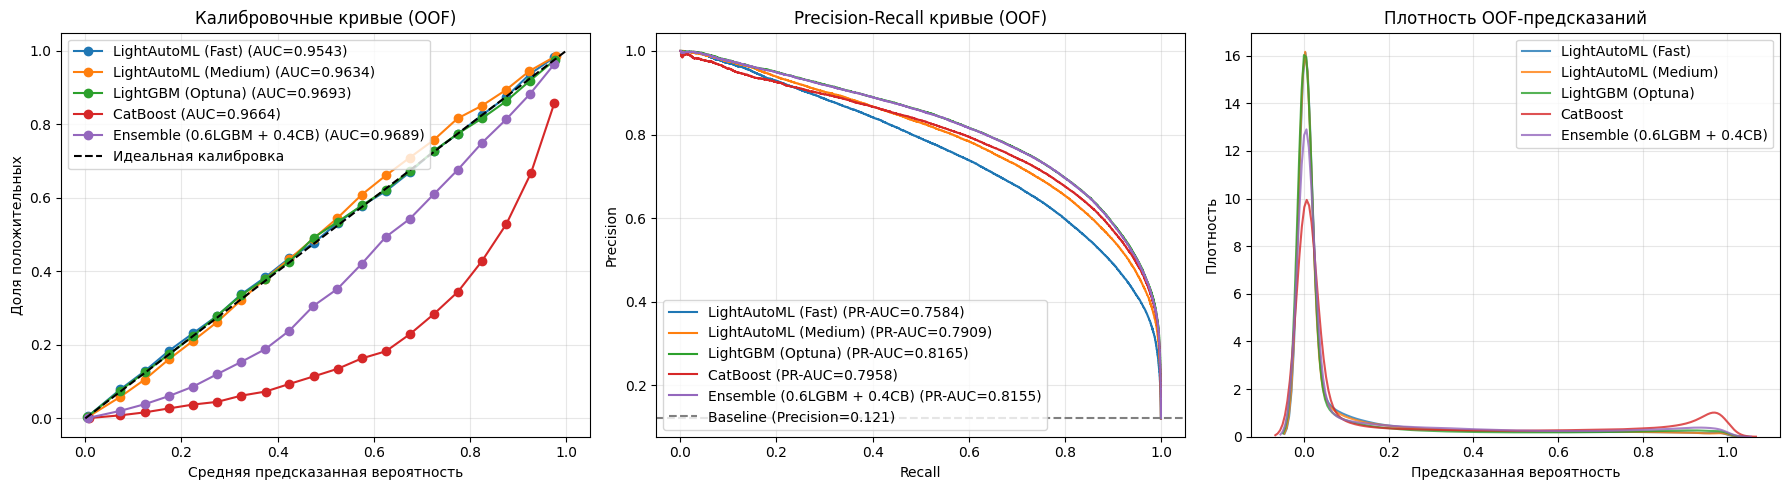


СВОДНАЯ ТАБЛИЦА МОДЕЛЕЙ (OOF)
Модель                         | ROC-AUC    | PR-AUC    
--------------------------------------------------------------------------------
LightAutoML (Fast)             | 0.95433    | 0.75843
LightAutoML (Medium)           | 0.96340    | 0.79092
LightGBM (Optuna)              | 0.96930    | 0.81652
CatBoost                       | 0.96642    | 0.79580
Ensemble (0.6LGBM + 0.4CB)     | 0.96894    | 0.81549


In [73]:
oof_predictions = {
    "LightAutoML (Fast)": oof_fast.data[:, 0],
    "LightAutoML (Medium)": oof_med.data[:, 0],
    "LightGBM (Optuna)": oof_lgb,
    "CatBoost": oof_cb,
    "Ensemble (0.6LGBM + 0.4CB)": ensemble_oof
}

assert all(len(pred) == len(y) for pred in oof_predictions.values()), "Несовпадение длины OOF-предсказаний!"

# 1. Калибровочные кривые
plt.figure(figsize=(18, 5))

plt.subplot(1, 3, 1)
for name, preds in oof_predictions.items():
    prob_true, prob_pred = calibration_curve(y, preds, n_bins=20)
    auc = roc_auc_score(y, preds)
    plt.plot(prob_pred, prob_true, 'o-', label=f'{name} (AUC={auc:.4f})')

plt.plot([0, 1], [0, 1], 'k--', label='Идеальная калибровка')
plt.title('Калибровочные кривые (OOF)')
plt.xlabel('Средняя предсказанная вероятность')
plt.ylabel('Доля положительных')
plt.legend()
plt.grid(True, alpha=0.3)

# 2. Precision-Recall кривые
plt.subplot(1, 3, 2)
for name, preds in oof_predictions.items():
    prec, rec, _ = precision_recall_curve(y, preds)
    pr_auc = average_precision_score(y, preds)
    plt.plot(rec, prec, label=f'{name} (PR-AUC={pr_auc:.4f})')

baseline = y.mean()
plt.axhline(y=baseline, color='gray', linestyle='--', label=f'Baseline (Precision={baseline:.3f})')
plt.title('Precision-Recall кривые (OOF)')
plt.xlabel('Recall')
plt.ylabel('Precision')
plt.legend()
plt.grid(True, alpha=0.3)

# 3. Распределение OOF-предсказаний
plt.subplot(1, 3, 3)
for name, preds in oof_predictions.items():
    sns.kdeplot(preds, label=name, alpha=0.8)
plt.title('Плотность OOF-предсказаний')
plt.xlabel('Предсказанная вероятность')
plt.ylabel('Плотность')
plt.legend()
plt.grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

# 4. Сводная таблица метрик
print("\n" + "="*80)
print("СВОДНАЯ ТАБЛИЦА МОДЕЛЕЙ (OOF)")
print("="*80)
print(f"{'Модель':<30} | {'ROC-AUC':<10} | {'PR-AUC':<10}")
print("-"*80)
for name, preds in oof_predictions.items():
    roc = roc_auc_score(y, preds)
    pr = average_precision_score(y, preds)
    print(f"{name:<30} | {roc:.5f}    | {pr:.5f}")
print("="*80)

Проведён полный EDA с визуализацией и обоснованием
Реализованы два LAMA-бейзлайна и три кастомных пайплайна: LightGBM (с Optuna), CatBoost, ансамбль
Загрузил на kaggle результат final_submission.csv получился скор 0.96995
Все критерии проекта выполнены (надеюсь), удалось превзойти результаты LAMA (не так на много, так как LAMA отлично себя показала )